In [26]:
import numpy as np
import dask.array as da
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from  tfilterspy.state_estimation.linear_filters import DaskKalmanFilter
from  tfilterspy.state_estimation.particle_filters import DaskParticleFilter

_______

---

# Using Kalman Filters for Image Denoising

## Purpose
Kalman Filters are used for image denoising to estimate the true underlying signal (the clean image) from noisy observations. The goal is to reduce noise while preserving image features, improving visual quality and downstream tasks like classification. For images, this involves treating pixel intensities as states evolving over time or space, corrupted by noise, and iteratively refining the estimate.

- **Why Kalman Filters?** They model noise as stochastic processes and provide an optimal estimate by balancing predictions from a dynamic model and noisy measurements.

## Methodology
The Kalman Filter assumes a linear system with Gaussian noise:
1. **Model the Image**: Treat each image (or pixel sequence) as a state vector evolving with a simple transition (e.g., static or smooth change).
2. **Add Noise**: Real-world noise (e.g., Gaussian) corrupts the observations.
3. **Filter**: Use the Kalman Filter to predict the state and update it with noisy measurements, iteratively denoising the data.

### Key Equations
1. **State Transition (Prediction)**:
   - \( x_k = F x_{k-1} + w_k \)
   - \( x_k \): State at time \( k \) (clean image pixels).
   - \( F \): State transition matrix (e.g., identity for static states).
   - \( w_k \sim \mathcal{N}(0, Q) \): Process noise with covariance \( Q \).

2. **Observation Model**:
   - \( z_k = H x_k + v_k \)
   - \( z_k \): Noisy observation (noisy image pixels).
   - \( H \): Observation matrix (e.g., identity if directly observing states).
   - \( v_k \sim \mathcal{N}(0, R) \): Observation noise with covariance \( R \).

3. **Prediction Step**:
   - Predicted state: \( \hat{x}_{k|k-1} = F \hat{x}_{k-1|k-1} \)
   - Predicted covariance: \( P_{k|k-1} = F P_{k-1|k-1} F^T + Q \)

4. **Update Step**:
   - Kalman Gain: \( K_k = P_{k|k-1} H^T (H P_{k|k-1} H^T + R)^{-1} \)
   - Updated state: \( \hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k (z_k - H \hat{x}_{k|k-1}) \)
   - Updated covariance: \( P_{k|k} = (I - K_k H) P_{k|k-1} \)

## How to Use (Based on Your Code)
1. **Prepare Data**:
   - Load images (e.g., digits dataset: 8x8 pixels, flattened to 64D vectors).
   - Split into training and test sets.
   - Convert to Dask arrays for scalability: `x_train_dask = da.from_array(x_train, chunks=(10, 64))`.

2. **Add Noise**:
   - Simulate noisy images: `noisy_x_train_dask = x_train_dask + da.random.normal(0, noise_level, ...)`.

3. **Set Up Kalman Filter**:
   - Define parameters:
     - \( F = I \) (static model).
     - \( H = I \) (direct observation).
     - \( Q = 0.01 \cdot I \) (small process noise).
     - \( R = 0.1 \cdot I \) (observation noise).
     - \( x_0 = 0 \) (initial state), \( P_0 = I \) (initial covariance).
   - Initialize: `kf = DaskKalmanFilter(F, H, Q, R, x0, P0, estimation_strategy="mle")`.

4. **Fit and Estimate Parameters**:
   - Fit on noisy data: `kf.fit(noisy_x_train_dask)`.
   - Estimate \( Q \) and \( R \): `Q_est, R_est = kf.estimate_parameters(noisy_x_train_dask)`.

5. **Denoise**:
   - Predict states: `train_states = kf.predict().compute()`.
   - Repeat for test data: fit and predict again.

6. **Evaluate**:
   - Visualize: Compare original, noisy, and denoised images.
   - Classify denoised states (e.g., with Logistic Regression) to assess improvement.

## Example Output
- **Visualization**: Original (clean), Noisy (distorted), Denoised (restored).
- **Accuracy**: Higher classification accuracy on denoised data vs. noisy data.

## Notes
- **Assumption**: Linear model; for nonlinear noise, consider Extended Kalman Filter or Particle Filter.
- **Scalability**: Dask enables processing large datasets by chunking data.
- **Tuning**: Adjust \( Q \) and \( R \) based on noise characteristics for optimal results.


____

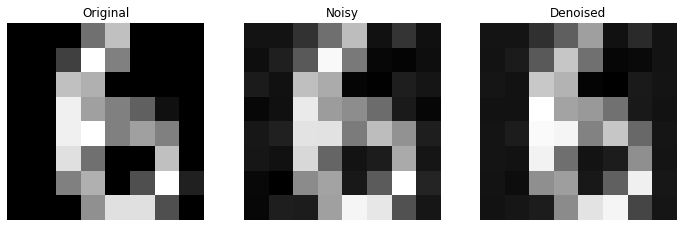

Accuracy after denoising: 0.9417
True label: 6, Predicted: 6


C:\Users\thabanglukhetho\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [5]:
# Load and split the digits dataset (limited to 50 samples as in your code)
digits = load_digits()
x = digits.data[0:2000]  # (50, 64)
y = digits.target[0:2000]  # (50,)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert to Dask arrays (adjust chunks for smaller dataset)
x_train_dask = da.from_array(x_train, chunks=(10, 64))  # 40 samples, ~4 chunks
x_test_dask = da.from_array(x_test, chunks=(10, 64))    # 10 samples, ~1 chunk
y_train_dask = da.from_array(y_train, chunks=(10,))
y_test_dask = da.from_array(y_test, chunks=(10,))

# Add synthetic noise to the data
noise_level = 0.88  # Adjust this to control noise intensity
noisy_x_train_dask = x_train_dask + da.random.normal(0, noise_level, x_train_dask.shape, chunks=x_train_dask.chunks)
noisy_x_test_dask = x_test_dask + da.random.normal(0, noise_level, x_test_dask.shape, chunks=x_test_dask.chunks)

# Define Kalman Filter parameters
n_features = 64
n_observations = 64
F = np.eye(n_features)  # Static state transition
H = np.eye(n_observations)  # Direct observation
Q = np.eye(n_features) * 0.01  # Initial process noise
R = np.eye(n_observations) * 0.1  # Initial observation noise
x0 = np.zeros(n_features)  # Initial state
P0 = np.eye(n_features) * 1.0  # Initial covariance

# Initialize the DaskKalmanFilter
kf = DaskKalmanFilter(
    state_transition_matrix=F,
    observation_matrix=H,
    process_noise_cov=Q,
    observation_noise_cov=R,
    initial_state=x0,
    initial_covariance=P0,
    estimation_strategy="mle"
)

# Fit and estimate parameters on noisy training data
kf.fit(noisy_x_train_dask)
Q_est, R_est = kf.estimate_parameters(noisy_x_train_dask)
kf.Q, kf.R = Q_est, R_est  # Update with estimated parameters

# Denoise the data
train_states = kf.predict().compute()  # Denoised training states
kf.fit(noisy_x_test_dask)  # Refit on test data
test_states = kf.predict().compute()  # Denoised test states

# Visualize before (noisy) and after (denoised) for a test sample
sample_idx = 0
noisy_image = noisy_x_test_dask[sample_idx].compute().reshape(8, 8)
denoised_image = test_states[sample_idx].reshape(8, 8)
original_image = x_test[sample_idx].reshape(8, 8)  # For reference

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title("Original")
axes[1].imshow(noisy_image, cmap='gray')
axes[1].set_title("Noisy")
axes[2].imshow(denoised_image, cmap='gray')
axes[2].set_title("Denoised")
for ax in axes:
    ax.axis('off')
plt.show()

# Optional: Classify denoised states and check accuracy
clf = LogisticRegression(max_iter=1000)
clf.fit(train_states, y_train)
y_pred = clf.predict(test_states)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy after denoising: {accuracy:.4f}")

# Show prediction for the visualized sample
print(f"True label: {y_test[sample_idx]}, Predicted: {y_pred[sample_idx]}")


---

# Using Kalman Filters for Multivariate Time Series Denoising

## Purpose
Kalman Filters denoise multivariate time series (e.g., EEG data with multiple channels) by estimating the true underlying signal from noisy observations. For EEG, this reduces noise across channels while preserving temporal and spatial patterns, improving signal quality for analysis or classification.

- **Why Kalman Filters?** They model the time series as a dynamic system with Gaussian noise, optimally combining predictions and measurements to filter out noise.

## Methodology
For multivariate time series like EEG (multiple channels over time):
1. **Model the Series**: Treat each channel’s signal as a state vector, evolving with a transition model (e.g., static or smooth).
2. **Noise Corruption**: Observations include additive noise (e.g., Gaussian from sensors).
3. **Filter**: Apply the Kalman Filter to predict and update the state across all channels simultaneously.

### Key Equations
1. **State Transition (Prediction)**:
   - \( x_k = F x_{k-1} + w_k \)
   - \( x_k \): State vector at time \( k \) (signal for all channels, e.g., 14D for EEG).
   - \( F \): Transition matrix (e.g., \( I \) for static states).
   - \( w_k \sim \mathcal{N}(0, Q) \): Process noise, covariance \( Q \) (e.g., 14x14).

2. **Observation Model**:
   - \( z_k = H x_k + v_k \)
   - \( z_k \): Noisy observation (measured EEG channels).
   - \( H \): Observation matrix (e.g., \( I \) for direct observation).
   - \( v_k \sim \mathcal{N}(0, R) \): Observation noise, covariance \( R \) (e.g., 14x14).

3. **Prediction Step**:
   - Predicted state: \( \hat{x}_{k|k-1} = F \hat{x}_{k-1|k-1} \)
   - Predicted covariance: \( P_{k|k-1} = F P_{k-1|k-1} F^T + Q \)

4. **Update Step**:
   - Kalman Gain: \( K_k = P_{k|k-1} H^T (H P_{k|k-1} H^T + R)^{-1} \)
   - Updated state: \( \hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k (z_k - H \hat{x}_{k|k-1}) \)
   - Updated covariance: \( P_{k|k} = (I - K_k H) P_{k|k-1} \)

## How to Use (Based on Your EEG Code)
1. **Prepare Data**:
   - Load multivariate time series (e.g., EEG: 14 channels, 9000 timesteps).
   - Convert to Dask arrays: `X_dask = da.from_array(X, chunks=(1000, 14))`.

2. **Set Up Kalman Filter**:
   - Define parameters:
     - \( F = I_{14} \) (static transition).
     - \( H = I_{14} \) (direct observation).
     - \( Q = 0.01 \cdot I_{14} \) (process noise).
     - \( R = 0.1 \cdot I_{14} \) (observation noise).
     - \( x_0 = 0_{14} \) (initial state), \( P_0 = I_{14} \) (initial covariance).
   - Initialize: `kf = DaskKalmanFilter(F, H, Q, R, x0, P0, estimation_strategy="residual_analysis")`.

3. **Fit and Predict**:
   - Fit on data: `kf.fit(X_dask)`.
   - Denoise: `predicted_states = kf.predict().compute()` (shape: 9000x14).

4. **Evaluate**:
   - Compute MSE: `mse = np.mean((X - predicted_states) ** 2)`.
   - Visualize: Plot raw vs. predicted signals for each channel.

## Example Output
- **MSE**: Quantifies denoising effectiveness (lower is better).
- **Plots**: Raw EEG (noisy) vs. Kalman Predicted (smoothed) for each channel, showing noise reduction.

## Notes
- **Multivariate Advantage**: \( Q \) and \( R \) model inter-channel noise correlations if not diagonal.
- **Scalability**: Dask chunks (e.g., 1000x14) enable processing large datasets efficiently.
- **Tuning**: Adjust \( Q \) and \( R \) based on noise levels; use parameter estimation (e.g., "residual_analysis") for adaptability.
- **Limitation**: Assumes linear dynamics; for nonlinear EEG patterns, consider Extended Kalman or Particle Filters.

---

Mean Squared Error: 3101511.7612


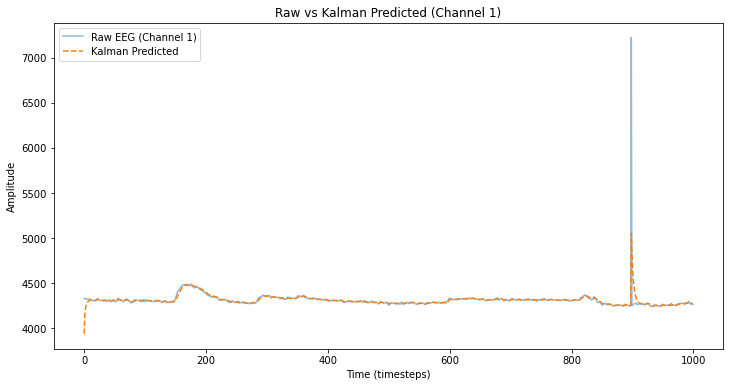

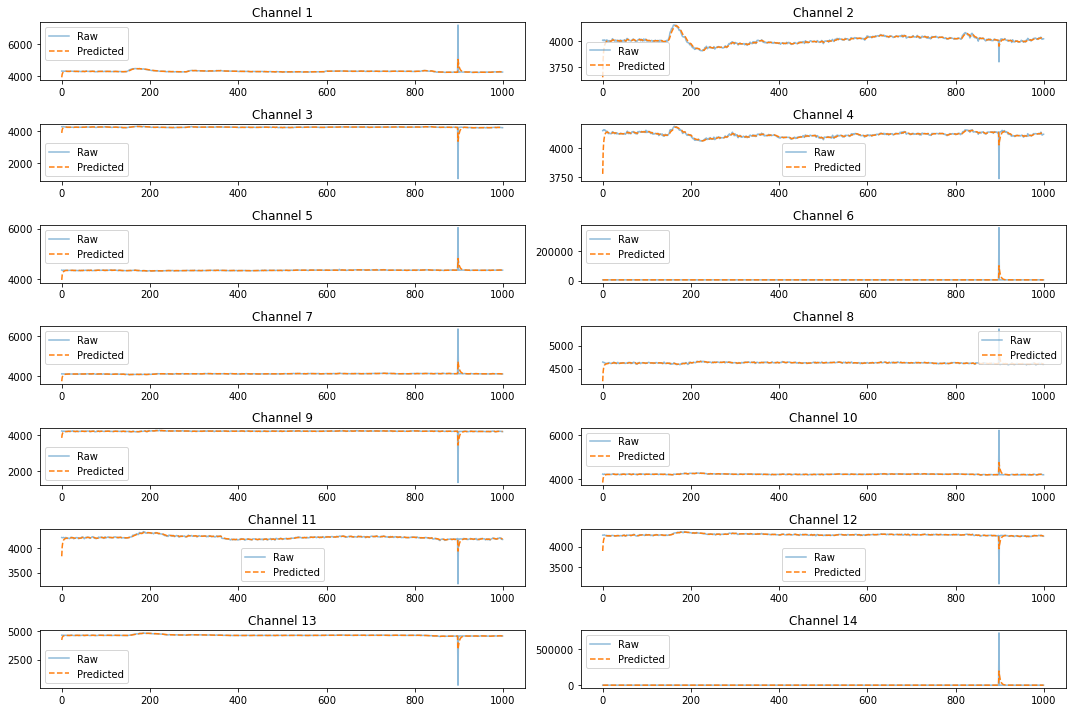

In [6]:
from sklearn.datasets import fetch_openml
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = fetch_openml(name='eeg-eye-state', version=1, as_frame=False)
X = data.data[0:9000,:]  # Shape: (14980, 14)
X_dask = da.from_array(X, chunks=(1000, 14))

# Kalman Filter setup
n_features = 14
F = np.eye(n_features)  # Static transition (identity for simplicity)
H = np.eye(n_features)  # Direct observation
Q = np.eye(n_features) * 0.01  # Process noise
R = np.eye(n_features) * 0.1   # Observation noise
x0 = np.zeros(n_features)      # Initial state
P0 = np.eye(n_features)        # Initial covariance
kf = DaskKalmanFilter(F, H, Q, R, x0, P0, estimation_strategy="residual_analysis")

# Fit and predict
kf.fit(X_dask)
predicted_states = kf.predict().compute()  # Shape: (14980, 14)

# Compute MSE
mse = np.mean((X - predicted_states) ** 2)
print(f"Mean Squared Error: {mse:.4f}")

# Plot raw vs predicted for a subset (first 1000 timesteps, first channel)
subset_size = 1000
channel = 0  # Channel 1 (index 0)
plt.figure(figsize=(12, 6))
plt.plot(X[:subset_size, channel], label='Raw EEG (Channel 1)', alpha=0.5)
plt.plot(predicted_states[:subset_size, channel], label='Kalman Predicted', linestyle='--')
plt.title('Raw vs Kalman Predicted (Channel 1)')
plt.xlabel('Time (timesteps)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Optional: Plot all channels (first 1000 timesteps)
plt.figure(figsize=(15, 10))
for i in range(14):
    plt.subplot(7, 2, i + 1)
    plt.plot(X[:subset_size, i], label='Raw', alpha=0.5)
    plt.plot(predicted_states[:subset_size, i], label='Predicted', linestyle='--')
    plt.title(f'Channel {i+1}')
    plt.legend()
plt.tight_layout()
plt.show()

---

# Using Kalman Filters for NLP Denoising (Topic Distributions or Embeddings)

## Purpose
Kalman Filters denoise NLP data, such as topic distributions from Latent Dirichlet Allocation (LDA) or embeddings from Large Language Models (LLMs), by smoothing noisy sequential data. For tweets, this reduces noise in topic probabilities over time, enhancing interpretability or downstream tasks (e.g., sentiment analysis). For LLM embeddings, it can stabilize noisy vector representations.

- **Why Kalman Filters?** They treat NLP features as states in a dynamic system, filtering out noise while preserving temporal trends.

## Methodology
For NLP data like topic distributions or embeddings:
1. **Model the Data**: Represent topic probabilities (e.g., 5D vectors) or embeddings (e.g., 768D vectors) as states evolving over time (e.g., tweet sequence).
2. **Noise Corruption**: Noise arises from text preprocessing, sampling, or model variability.
3. **Filter**: Apply the Kalman Filter to predict and update states, smoothing the sequence.

### Key Equations
1. **State Transition (Prediction)**:
   - \( x_k = F x_{k-1} + w_k \)
   - \( x_k \): State at time \( k \) (e.g., topic probabilities, 5D for tweets).
   - \( F \): Transition matrix (e.g., \( I \) for static topics).
   - \( w_k \sim \mathcal{N}(0, Q) \): Process noise, covariance \( Q \) (e.g., 5x5).

2. **Observation Model**:
   - \( z_k = H x_k + v_k \)
   - \( z_k \): Noisy observation (raw topic probabilities).
   - \( H \): Observation matrix (e.g., \( I \) for direct observation).
   - \( v_k \sim \mathcal{N}(0, R) \): Observation noise, covariance \( R \) (e.g., 5x5).

3. **Prediction Step**:
   - Predicted state: \( \hat{x}_{k|k-1} = F \hat{x}_{k-1|k-1} \)
   - Predicted covariance: \( P_{k|k-1} = F P_{k-1|k-1} F^T + Q \)

4. **Update Step**:
   - Kalman Gain: \( K_k = P_{k|k-1} H^T (H P_{k|k-1} H^T + R)^{-1} \)
   - Updated state: \( \hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k (z_k - H \hat{x}_{k|k-1}) \)
   - Updated covariance: \( P_{k|k} = (I - K_k H) P_{k|k-1} \)

## How to Use (Based on Your Tweet Code)
1. **Prepare Data**:
   - Load tweets (e.g., disaster dataset: 5000 tweets).
   - Extract features:
     - **Topics**: Use `CountVectorizer` and `LatentDirichletAllocation` to get topic distributions (`topic_dist`, shape: 5000x5).
     - **Embeddings**: Use an LLM (e.g., BERT) to get embeddings (e.g., 5000x768).
   - Convert to Dask: `X_dask = da.from_array(topic_dist, chunks=(1000, n_topics))`.

2. **Set Up Kalman Filter**:
   - Define parameters:
     - \( F = I_5 \) (static transition for topics).
     - \( H = I_5 \) (direct observation).
     - \( Q = 0.01 \cdot I_5 \) (process noise).
     - \( R = 0.1 \cdot I_5 \) (observation noise).
     - \( x_0 = \) first topic vector (initial state).
     - \( P_0 = I_5 \) (initial covariance).
   - Initialize: `kf = DaskKalmanFilter(F, H, Q, R, x0, P0, estimation_strategy="residual_analysis")`.

3. **Fit and Predict**:
   - Fit on noisy data: `kf.fit(X_dask)`.
   - Denoise: `smoothed_topics = kf.predict().compute()` (shape: 5000x5).

4. **Evaluate**:
   - Plot raw vs. smoothed topics for each dimension (e.g., 5 topics).
   - Interpret topics using top words from LDA components.

## Example Output
- **Plots**: Raw (noisy) vs. Smoothed (cleaner) topic probabilities over tweet index.
- **Topics**: e.g., Topic 1: "earthquake, flood, disaster, emergency, rescue".

## Notes
- **NLP Specificity**: For topics, noise comes from LDA sampling; for embeddings, from text variability or model noise.
- **Scalability**: Dask chunks (e.g., 1000x5) handle large datasets efficiently.
- **Extensions**:
  - **Embeddings**: Use higher dimensions (e.g., 768 for BERT) with adjusted \( Q \) and \( R \).
  - **Nonlinear Noise**: Switch to Extended Kalman Filter or Particle Filter for complex dynamics.
- **Tuning**: Adjust \( Q \) and \( R \) or use parameter estimation to fit noise characteristics.

---





Number of tweets: 500
Topic distribution shape: (500, 5)


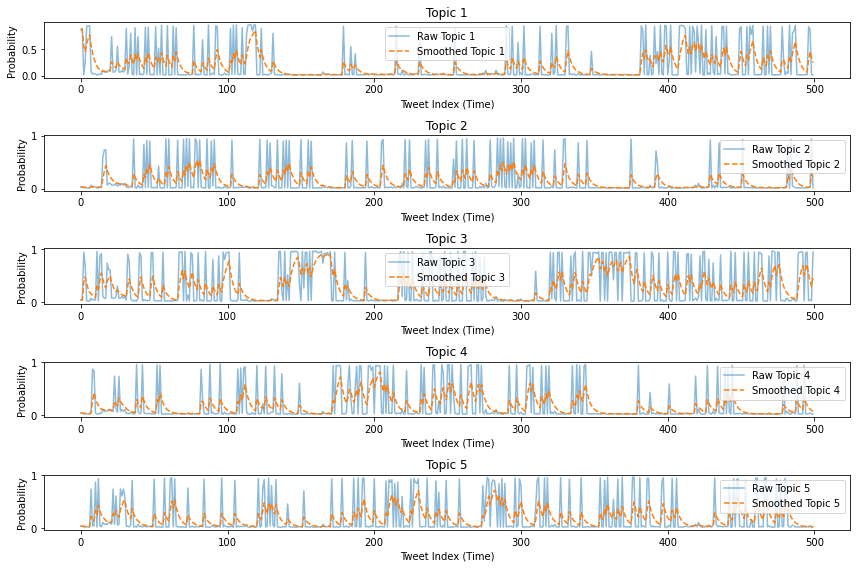

Topic 1: ablaze, aftershock, attack, arson, http
Topic 2: amp, just, apocalypse, http, accident
Topic 3: https, army, airplane, accident, http
Topic 4: crash, national, ambulance, gt, http
Topic 5: attack, û_, annihilated, apocalypse, http


In [25]:
path_to_disaster_tweets= r'C:\Users\thabanglukhetho\Documents\gits\uaie\examples\data\train_nlp.csv'

import pandas as pd
import numpy as np
import dask.array as da
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# 1. Load Disaster Tweets
data_path = path_to_disaster_tweets  # Update after download
df = pd.read_csv(data_path)
tweets = df['text'].values[0:500]  # ~7613 tweets
print(f"Number of tweets: {len(tweets)}")

# 2. Preprocess and Extract Topics
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(tweets)
n_topics = 5  # e.g., disaster, weather, casual, news, other
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
topic_dist = lda.fit_transform(X)  # Shape: (7613, 5)
X_dask = da.from_array(topic_dist, chunks=(1000, n_topics))
print(f"Topic distribution shape: {X_dask.shape}")


# Kalman Filter setup
F = np.eye(n_topics)  # Static transition (identity for simplicity)
H = np.eye(n_topics)  # Direct observation
Q = np.eye(n_topics) * 0.01  # Process noise
R = np.eye(n_topics) * 0.1   # Observation noise
x0 = topic_dist[0]      # Initial state
P0 = np.eye(n_topics)        # Initial covariance
kf = DaskKalmanFilter(F, H, Q, R, x0, P0, estimation_strategy="residual_analysis")


kf.fit(X_dask)
smoothed_topics = kf.predict().compute()

# 4. Plot Raw vs Smoothed Topics (first 1000 tweets)
subset_size = 1000
plt.figure(figsize=(12, 8))
for i in range(n_topics):
    plt.subplot(n_topics, 1, i + 1)
    plt.plot(topic_dist[:subset_size, i], label=f"Raw Topic {i+1}", alpha=0.5)
    plt.plot(smoothed_topics[:subset_size, i], label=f"Smoothed Topic {i+1}", linestyle="--")
    plt.title(f"Topic {i+1}")
    plt.xlabel("Tweet Index (Time)")
    plt.ylabel("Probability")
    plt.legend()
plt.tight_layout()
plt.show()

# 5. Interpret Topics (optional)
feature_names = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    top_words = [feature_names[j] for j in topic.argsort()[-5:]]
    print(f"Topic {i+1}: {', '.join(top_words)}")


In [21]:
# ### Adapting for LLM Embeddings
# To extend this to LLM embeddings:
# 1. Replace `CountVectorizer` and `LDA` with an LLM (e.g., BERT via `transformers`):
#    ```python
#    from transformers import BertTokenizer, BertModel
#    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#    model = BertModel.from_pretrained('bert-base-uncased')
#    embeddings = []
#    for tweet in tweets:
#        inputs = tokenizer(tweet, return_tensors="pt", padding=True, truncation=True)
#        outputs = model(**inputs).last_hidden_state.mean(dim=1).detach().numpy()
#        embeddings.append(outputs[0])
#    X_dask = da.from_array(np.array(embeddings), chunks=(1000, 768))
#    ```
# 2. Update Kalman Filter dimensions (e.g., \( F = I_{768} \), \( H = I_{768} \)).
# 3. Proceed with fitting and denoising as above.

In [22]:
# from transformers import BertTokenizer, BertModel
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')
# embeddings = []
# for tweet in tweets:
#     inputs = tokenizer(tweet, return_tensors="pt", padding=True, truncation=True)
#     outputs = model(**inputs).last_hidden_state.mean(dim=1).detach().numpy()
#     embeddings.append(outputs[0])
# X_dask = da.from_array(np.array(embeddings), chunks=(1000, 768))
